## Description

**Overview**<br>
Identify top countries that are in direst need of aid. our job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then we need to suggest the countries which the CEO needs to focus on the most

The steps are broadly:

1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis

# 1. Read and visualise the data

In [128]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [129]:
# read the dataset
country_df = pd.read_csv("Country-data.csv")
country_df_Org = country_df.copy()
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [130]:
# basics of the df
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


# 2. Clean the data

In [131]:
# missing values
round(100*(country_df.isnull().sum())/len(country_df), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

In [132]:
# drop all rows having missing values
country_df = country_df.dropna()
country_df.shape

(167, 10)

# 3.Preparing the data:-
###### converting the % column(exports,imports and health) into actual number to make proper sense of data as percentage column can be misleading sometimes.

In [133]:

country_df['exports'] = round((country_df['exports']*country_df['gdpp']/100),2)
country_df['imports'] = round((country_df['imports']*country_df['gdpp']/100),2)
country_df['health'] = round((country_df['health']*country_df['gdpp']/100),2)
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


In [134]:
# after changing the % into numbers and cleaning the shape of data remains the same
country_df.shape

(167, 10)

##### Univariate and Bi-variate analysis

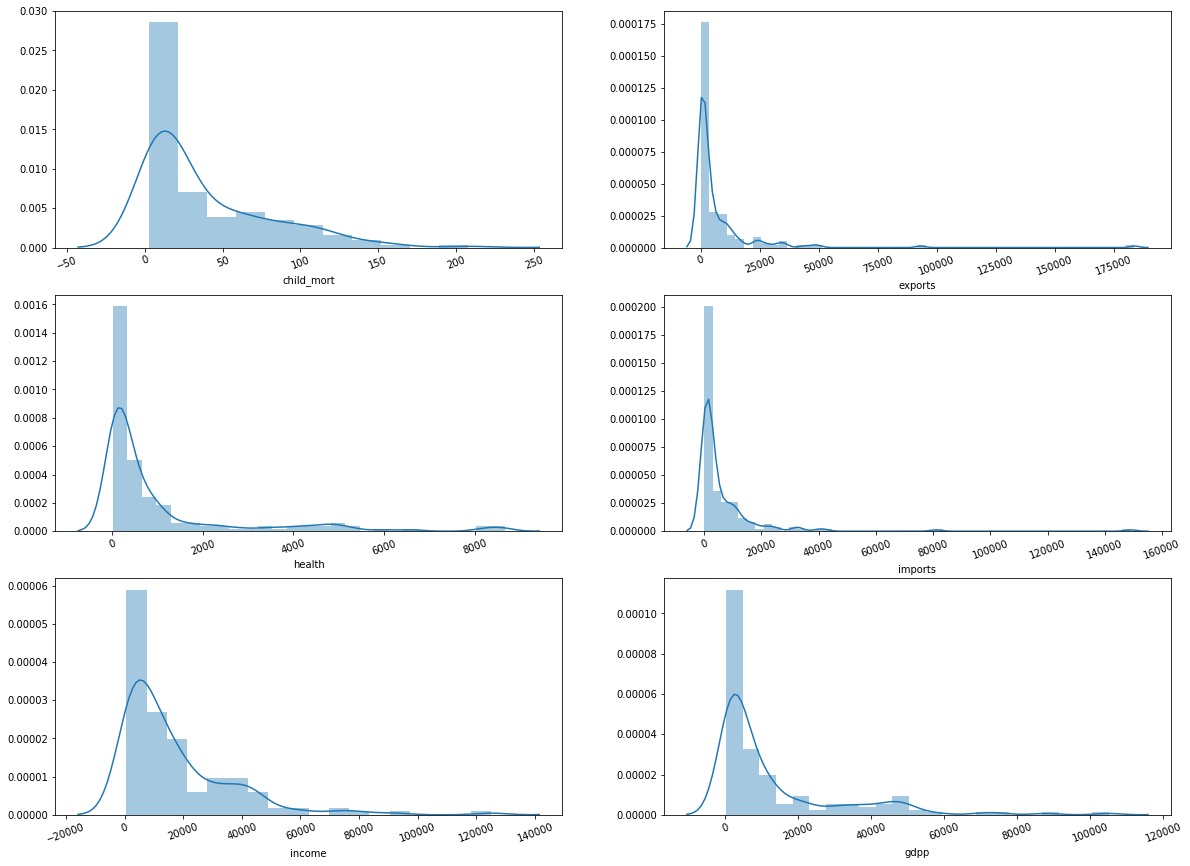

In [135]:
plt.figure(figsize=(20,20))
country_position = ['child_mort', 'exports', 'health', 'imports','income','gdpp']
for i in enumerate(country_position): 
    ax = plt.subplot(4, 2, i[0]+1)
    sns.distplot(country_df[i[1]])
    plt.xticks(rotation = 20)

from above plots we can guess that exports,health and imports are showing normal distribution and suggests that most of the countries lies in a proper cluster **however child_mort, income and gdpp shows almost two clusters or concentraion(i.e. a great variation) in each of them.**

In [136]:
# gdpp variation across countries
country_df.gdpp.describe()

count       167.000000
mean      12964.155689
std       18328.704809
min         231.000000
25%        1330.000000
50%        4660.000000
75%       14050.000000
max      105000.000000
Name: gdpp, dtype: float64

In [137]:
# income variation across countries
country_df.income.describe()

count       167.000000
mean      17144.688623
std       19278.067698
min         609.000000
25%        3355.000000
50%        9960.000000
75%       22800.000000
max      125000.000000
Name: income, dtype: float64

In [138]:
# child_mort variation across countries
country_df.child_mort.describe()

count    167.000000
mean      38.270060
std       40.328931
min        2.600000
25%        8.250000
50%       19.300000
75%       62.100000
max      208.000000
Name: child_mort, dtype: float64

#### Average number of deaths of children under 5 years of age per 1000 live births is 38.27 and maximum is 208(alarming).

In [139]:
# exports variation across countries
country_df.exports.describe()

count       167.000000
mean       7420.618862
std       17973.885789
min           1.080000
25%         447.140000
50%        1777.440000
75%        7278.000000
max      183750.000000
Name: exports, dtype: float64

In [140]:
# health variation across countries
country_df.health.describe()

count     167.000000
mean     1056.733174
std      1801.408921
min        12.820000
25%        78.535000
50%       321.890000
75%       976.940000
max      8663.600000
Name: health, dtype: float64

#### countries average health spending per capita is 1056.733174.

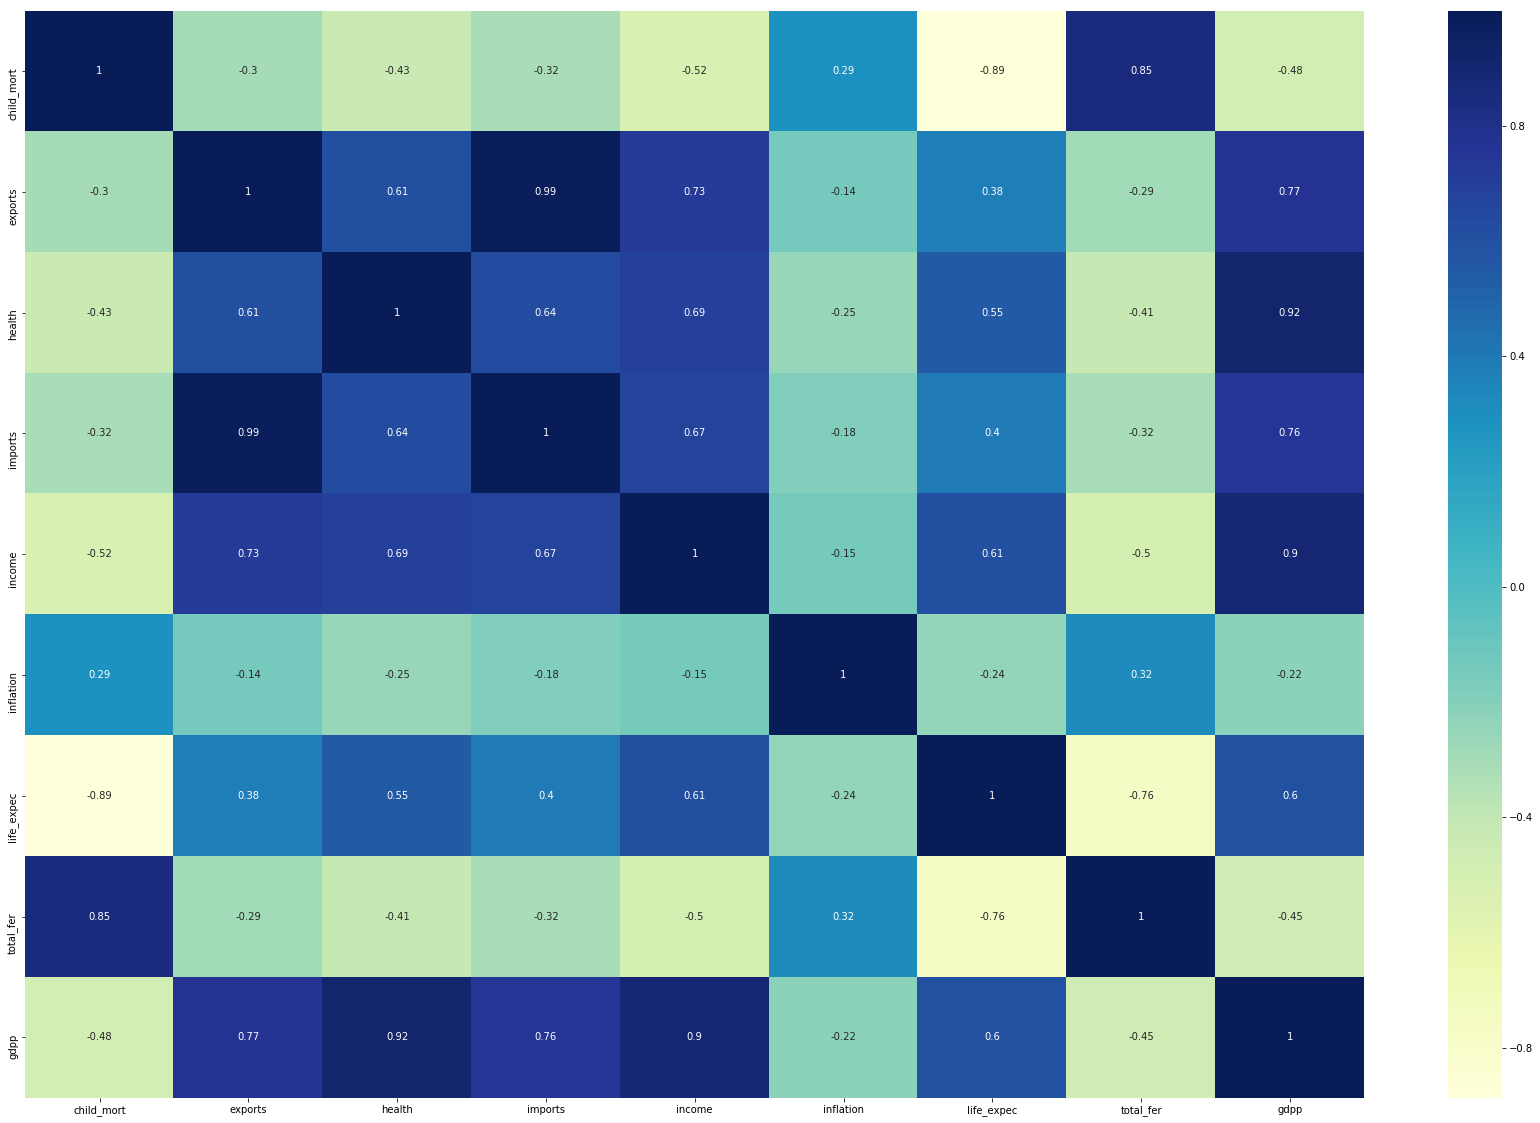

In [141]:
#correlation between all the numeric variables
plt.figure(figsize=(30,20))
sns.heatmap(country_df.corr(), annot=True, cmap='YlGnBu')
plt.show()

from above heatmap few crucial points that comes out:-
    - it becomes quite evident that exports has serious correlation with income and import of a country.
    - other intresting facts are that gdpp directly effects health expenditure of a country.
    - gdpp has strong relation with income.
    - also total age-fertility rate correlates with child_mortality rate as well.

### Outlier treatment

In [142]:
country_df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

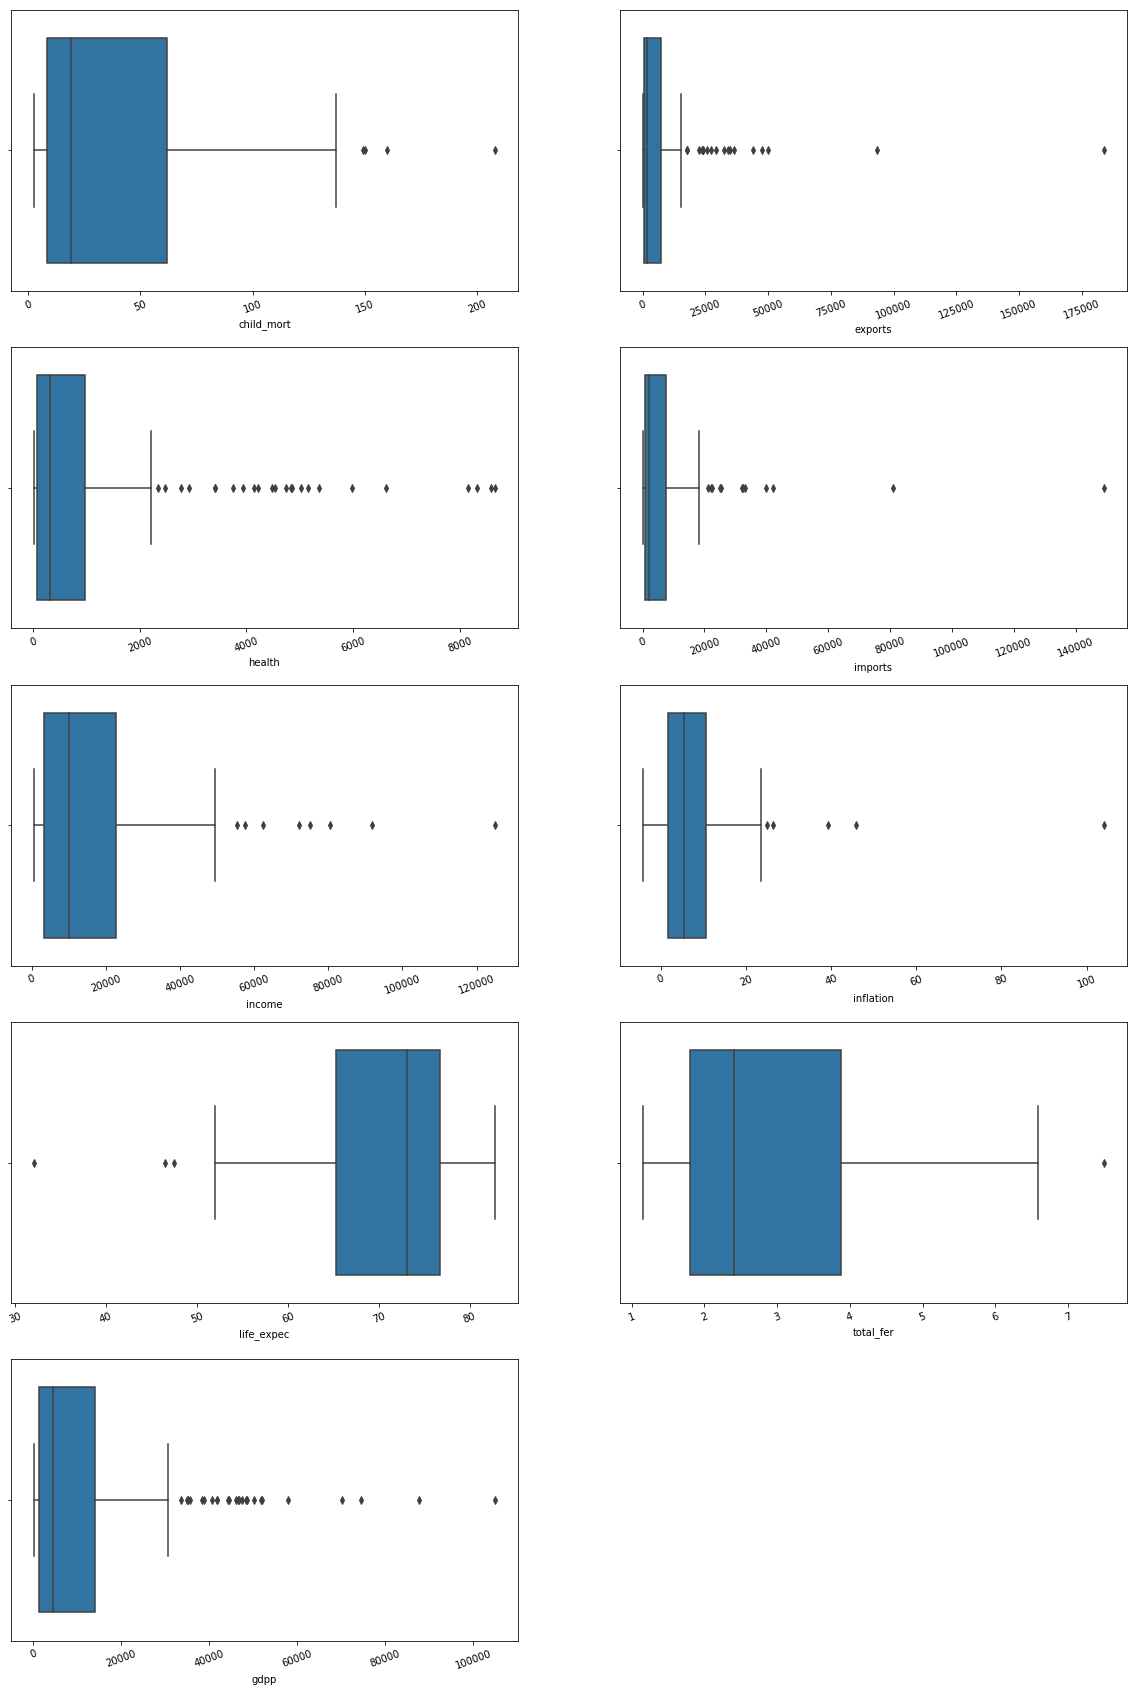

In [143]:
plt.figure(figsize=(20,30))
col = ['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']
for i in enumerate(col): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.boxplot(x=i[1], data=country_df)
    plt.xticks(rotation = 20)

#### outlier treatment of child_mort

In [144]:
country_df.child_mort.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    167.000000
mean      38.270060
std       40.328931
min        2.600000
1%         2.800000
25%        8.250000
50%       19.300000
75%       62.100000
90%      100.220000
95%      116.000000
99%      153.400000
max      208.000000
Name: child_mort, dtype: float64

#### we can clearly see that max child_mort number is quite high than 99% data so we will treat by replacing it with 99% value.

In [145]:
#outlier treatment of child_mort.
Q1 = country_df['child_mort'].quantile(0.01)
Q4 = country_df['child_mort'].quantile(0.99)
country_df['child_mort'][country_df['child_mort'] <= Q1]=Q1
country_df['child_mort'][country_df['child_mort'] >= Q4]=Q4
country_df.shape

(167, 10)

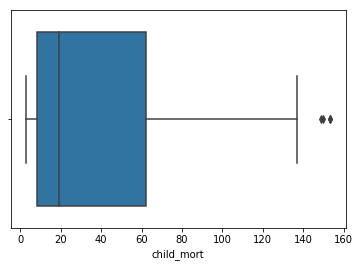

In [146]:
sns.boxplot(x='child_mort', data=country_df)

#### treatment of exports outlier.

In [147]:
country_df.exports.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count       167.000000
mean       7420.618862
std       17973.885789
min           1.080000
1%           22.246800
25%         447.140000
50%        1777.440000
75%        7278.000000
90%       17760.600000
95%       31385.100000
99%       64794.260000
max      183750.000000
Name: exports, dtype: float64

In [148]:
#outlier treatment of exports.
Q1 = country_df['exports'].quantile(0.01)
Q4 = country_df['exports'].quantile(0.95)
country_df['exports'][country_df['exports'] <= Q1]=Q1
country_df['exports'][country_df['exports'] >= Q4]=Q4
country_df.shape

(167, 10)

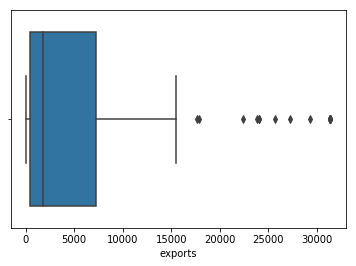

In [149]:
sns.boxplot(x='exports', data=country_df)

#### outlier treatment of health

In [150]:
country_df.health.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count     167.000000
mean     1056.733174
std      1801.408921
min        12.820000
1%         17.008800
25%        78.535000
50%       321.890000
75%       976.940000
90%      3825.416000
95%      4966.701000
99%      8410.330400
max      8663.600000
Name: health, dtype: float64

In [151]:
Q1 = country_df['health'].quantile(0.01)
Q4 = country_df['health'].quantile(0.99)
country_df['health'][country_df['health'] <= Q1]=Q1
country_df['health'][country_df['health'] >= Q4]=Q4
country_df.shape

(167, 10)

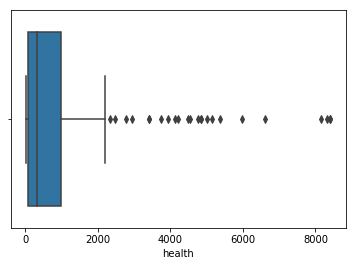

In [152]:
sns.boxplot(x='health', data=country_df)

#### outlier treatment of imports

In [153]:
country_df.imports.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count       167.000000
mean       6588.352096
std       14710.810423
min           0.650000
1%          104.911600
25%         640.215000
50%        2045.580000
75%        7719.600000
90%       15034.280000
95%       24241.560000
99%       55371.390000
max      149100.000000
Name: imports, dtype: float64

In [154]:
Q1 = country_df['imports'].quantile(0.01)
Q4 = country_df['imports'].quantile(0.99)
country_df['imports'][country_df['imports'] <= Q1]=Q1
country_df['imports'][country_df['imports'] >= Q4]=Q4
country_df.shape

(167, 10)

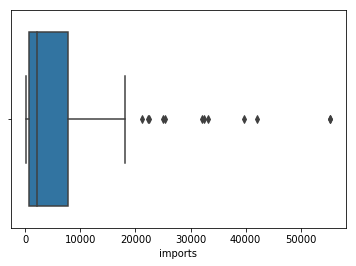

In [155]:
sns.boxplot(x='imports', data=country_df)

#### outlier treatment of imports

In [156]:
country_df.income.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count       167.000000
mean      17144.688623
std       19278.067698
min         609.000000
1%          742.240000
25%        3355.000000
50%        9960.000000
75%       22800.000000
90%       41220.000000
95%       48290.000000
99%       84374.000000
max      125000.000000
Name: income, dtype: float64

In [157]:
Q1 = country_df['income'].quantile(0.01)
Q4 = country_df['income'].quantile(0.99)
country_df['income'][country_df['income'] <= Q1]=Q1
country_df['income'][country_df['income'] >= Q4]=Q4
country_df.shape

(167, 10)

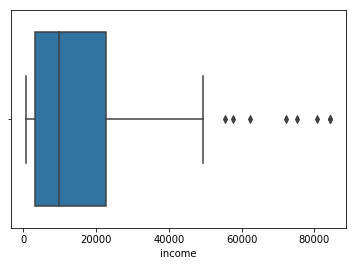

In [158]:
sns.boxplot(x='income', data=country_df)

#### outlier treatment of inflation

In [159]:
country_df.inflation.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    167.000000
mean       7.781832
std       10.570704
min       -4.210000
1%        -2.348800
25%        1.810000
50%        5.390000
75%       10.750000
90%       16.640000
95%       20.870000
99%       41.478000
max      104.000000
Name: inflation, dtype: float64

In [160]:
Q1 = country_df['inflation'].quantile(0.01)
Q4 = country_df['inflation'].quantile(0.95)
country_df['inflation'][country_df['inflation'] <= Q1]=Q1
country_df['inflation'][country_df['inflation'] >= Q4]=Q4
country_df.shape

(167, 10)

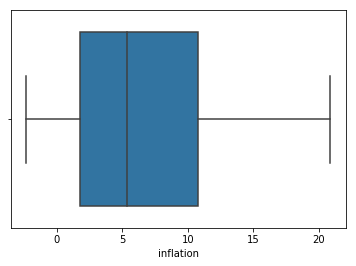

In [161]:
sns.boxplot(x='inflation', data=country_df)

#### outlier treatment of life_expec

In [162]:
country_df.life_expec.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    167.000000
mean      70.555689
std        8.893172
min       32.100000
1%        47.160000
25%       65.300000
50%       73.100000
75%       76.800000
90%       80.400000
95%       81.400000
99%       82.370000
max       82.800000
Name: life_expec, dtype: float64

In [163]:
Q1 = country_df['life_expec'].quantile(0.01)
Q4 = country_df['life_expec'].quantile(0.99)
country_df['life_expec'][country_df['life_expec'] <= Q1]=Q1
country_df['life_expec'][country_df['life_expec'] >= Q4]=Q4
country_df.shape

(167, 10)

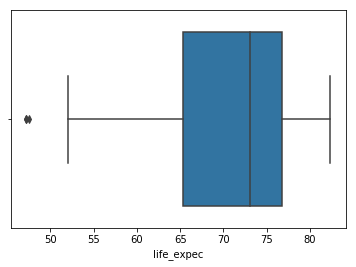

In [164]:
sns.boxplot(x='life_expec', data=country_df)

#### outlier treatment of gdpp

In [165]:
country_df.gdpp.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count       167.000000
mean      12964.155689
std       18328.704809
min         231.000000
1%          331.620000
25%        1330.000000
50%        4660.000000
75%       14050.000000
90%       41840.000000
95%       48610.000000
99%       79088.000000
max      105000.000000
Name: gdpp, dtype: float64

In [166]:
Q1 = country_df['gdpp'].quantile(0.01)
Q4 = country_df['gdpp'].quantile(0.99)
country_df['gdpp'][country_df['gdpp'] <= Q1]=Q1
country_df['gdpp'][country_df['gdpp'] >= Q4]=Q4
country_df.shape

(167, 10)

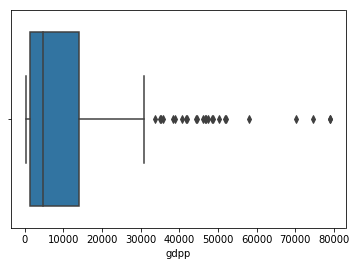

In [167]:
sns.boxplot(x='gdpp', data=country_df)

# 4. Modelling-Clustering

### Hopkins Test

In [168]:
country_df1 = country_df[['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']]

In [169]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [170]:
hopkins(country_df1)

0.9024609769006223

#### the hopkins test result shows greater than 90% which clearly says that the dataset have a good number of clusters.

## Scaling

In [171]:
# rescaling
# instantiate
scaler = StandardScaler()

# fit_transform
country_df1_scaled = scaler.fit_transform(country_df1)
country_df1_scaled.shape

(167, 9)

In [172]:
country_df1_scaled = pd.DataFrame(country_df1_scaled)
country_df1_scaled.columns = ['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']

In [173]:
country_df1_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344012,-0.669604,-0.566981,-0.598844,-0.851772,0.393469,-1.693799,1.902882,-0.702314
1,-0.547543,-0.542194,-0.440414,-0.413679,-0.387025,-0.387374,0.663053,-0.859973,-0.498775
2,-0.272548,-0.475859,-0.486296,-0.476198,-0.221124,1.444058,0.686504,-0.038404,-0.477483
3,2.084186,-0.418981,-0.534116,-0.464070,-0.612136,2.196506,-1.236499,2.128151,-0.531000
4,-0.709457,-0.027150,-0.178431,0.139659,0.125202,-0.868499,0.721681,-0.541946,-0.032079


In [174]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(country_df1_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [175]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 3, 2, 1, 3, 3, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 3, 1, 0, 0, 1, 0, 3, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 3,
       2, 1, 1, 1, 1, 0, 0, 3, 1, 3, 3, 0, 0, 1, 3, 0, 3, 1, 1, 0, 0, 1,
       0, 3, 3, 1, 1, 1, 0, 2, 3, 3, 1, 3, 1, 1, 0, 0, 3, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 3, 0, 0, 2, 3, 0, 1, 1, 1, 1, 1, 3, 2, 1, 1, 0, 1, 3, 0, 1, 1,
       0, 2, 3, 3, 0, 0, 3, 3, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0])

## Finding the Optimal Number of Clusters

### SSD

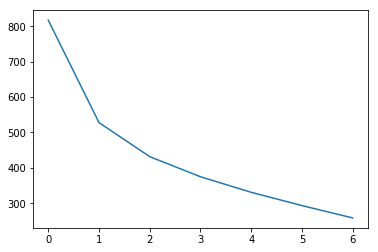

In [176]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_df1_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [177]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(country_df1_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(country_df1_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.47321130006317713
For n_clusters=3, the silhouette score is 0.4001535304814761
For n_clusters=4, the silhouette score is 0.37939309573042873
For n_clusters=5, the silhouette score is 0.3494802164489305
For n_clusters=6, the silhouette score is 0.30953346663376247
For n_clusters=7, the silhouette score is 0.31518073619358294
For n_clusters=8, the silhouette score is 0.33615886546627294


the silhouette score for k=2 is higher than all other n_cluster but it is relatively close to n_cluster=3.
so **we would be going with k=3** to have a better chance of beautiful cluster. 

In [178]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(country_df1_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [179]:
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [180]:
# assign the label
country_df = pd.concat([country_df.reset_index().drop('index', axis = 1), pd.Series(kmeans.labels_)], axis = 1)
country_df.columns = ['country', 'child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp','cluster_id']
country_df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.440,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.490,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.100,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,20.870,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.440,76.8,2.13,12200.0,1
5,Argentina,14.5,1946.70,834.30,1648.00,18700.0,20.870,75.8,2.37,10300.0,1
6,Armenia,18.1,669.76,141.68,1458.66,6700.0,7.770,73.3,1.69,3220.0,1
7,Australia,4.8,10276.20,4530.87,10847.10,41400.0,1.160,82.0,1.93,51900.0,2
8,Austria,4.3,24059.70,5159.00,22418.20,43200.0,0.873,80.5,1.44,46900.0,2
9,Azerbaijan,39.2,3171.12,343.39,1208.88,16000.0,13.800,69.1,1.92,5840.0,1


In [181]:
# Cross-check
country_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    0
dtype: int64

In [182]:
# Check the count of observation per cluster
country_df['cluster_id'].value_counts()

1    89
0    48
2    30
Name: cluster_id, dtype: int64

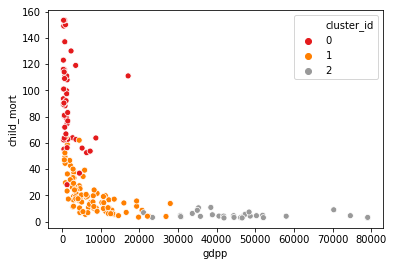

In [183]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

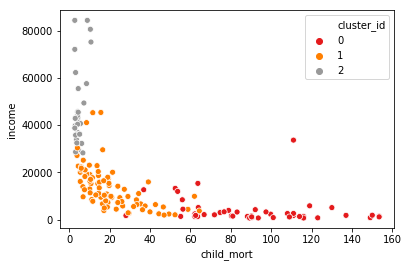

In [184]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'child_mort', y = 'income', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

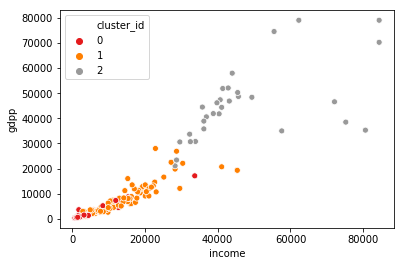

In [185]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'income', y = 'gdpp', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

## Cluster Profiling

In [186]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,20.87,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,1


In [187]:
country_df.groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,90.335417,879.097642,114.939325,827.327950,3901.010000,9.889271,59.567083,4.992083,1911.400833
1,20.726966,3395.983897,508.603258,3516.504288,13626.853933,6.732339,73.303371,2.233596,7552.494382
2,4.976667,20712.123333,4175.845027,20941.719333,47178.266667,2.868840,80.484667,1.796667,45552.533333


### from above table we can clrealy see that the cluster 1 has highest and worst child mortality rate with lowest income and gdpp.so cluster 1 needs to be closely looked at.

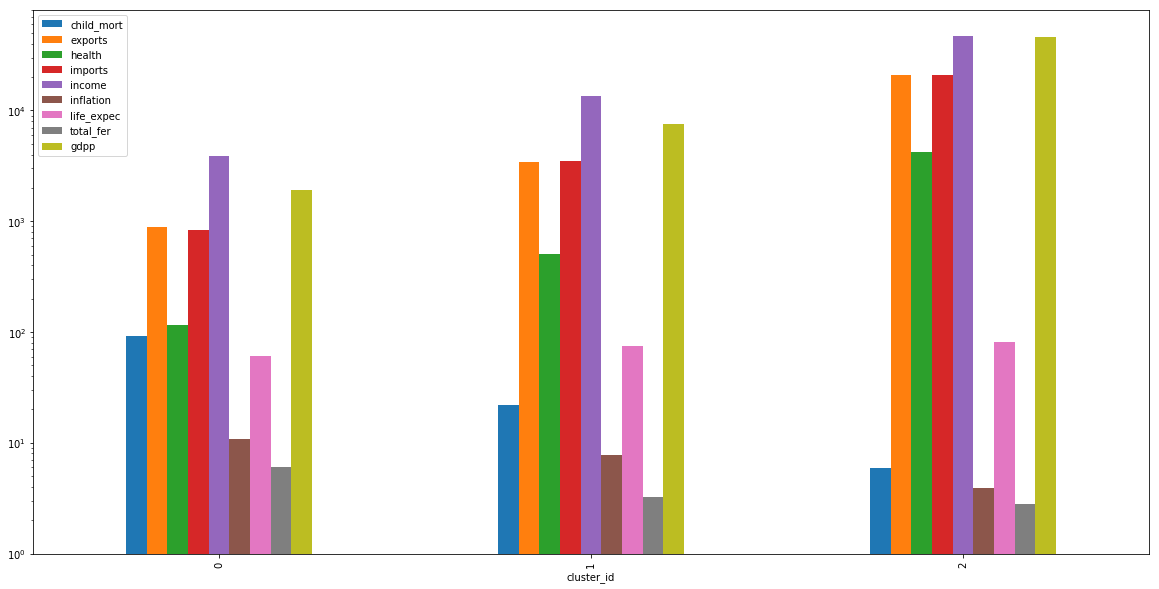

In [188]:

country_df.groupby('cluster_id').mean().plot(kind='bar', log=True,figsize=(20,10))

from above plot we can clearly understand these points:-
    - in clusters 0 the countries are having highest child mortatlity rate with low income and gdpp.
    - and exports and imports also shows the same trend in all three of the clusters.

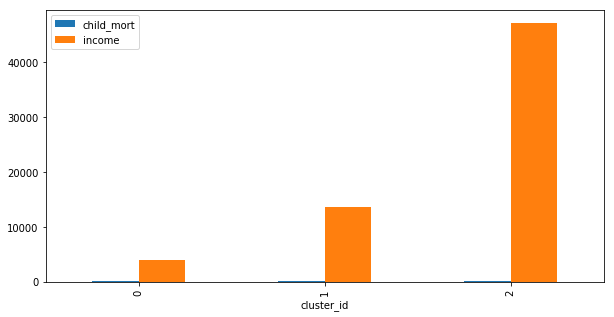

In [189]:
country_df[['child_mort','income', 'cluster_id']].groupby('cluster_id').mean().plot(kind = 'bar',figsize=(10, 5))

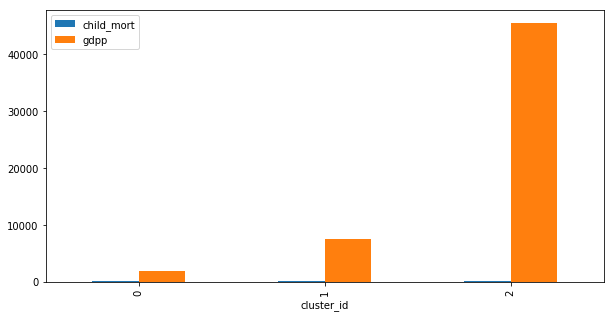

In [190]:
country_df[['child_mort','gdpp', 'cluster_id']].groupby('cluster_id').mean().plot(kind = 'bar',figsize=(10, 5))

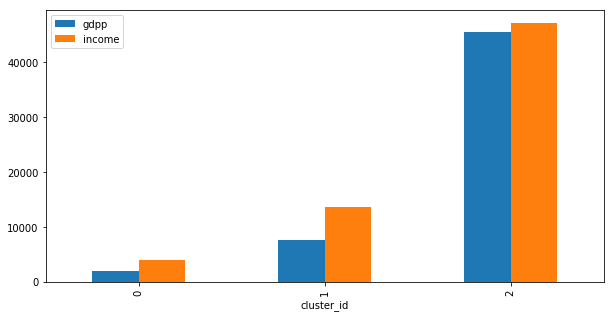

In [191]:
country_df[['gdpp','income', 'cluster_id']].groupby('cluster_id').mean().plot(kind = 'bar',figsize=(10, 5))

## Finding the observations that belong to certain cluster

In [193]:
#Let's use the concept of binning
country_df[country_df['cluster_id']==0]['country']

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

In [194]:
country_df[country_df['cluster_id']==0].sort_values(by=['gdpp', 'income', 'child_mort'], ascending=[True, True, False]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
88,Liberia,89.3,62.4600,38.5900,302.8000,742.24,5.47,60.8,5.02,331.62,0
26,Burundi,93.6,22.2468,26.8000,104.9116,764.00,12.30,57.7,6.26,331.62,0
37,"Congo, Dem. Rep.",116.0,137.2700,26.4200,165.6600,742.24,20.80,57.5,6.54,334.00,0
112,Niger,123.0,77.2600,17.9600,170.8700,814.00,2.55,58.8,7.49,348.00,0
132,Sierra Leone,153.4,67.0300,52.2700,137.6600,1220.00,17.20,55.0,5.20,399.00,0
93,Madagascar,62.2,103.2500,17.0088,177.5900,1390.00,8.79,60.8,4.60,413.00,0
106,Mozambique,101.0,131.9900,21.8300,193.5800,918.00,7.64,54.5,5.56,419.00,0
31,Central African Republic,149.0,52.6300,17.7500,118.1900,888.00,2.01,47.5,5.21,446.00,0
94,Malawi,90.5,104.6500,30.2500,160.1900,1030.00,12.10,53.1,5.31,459.00,0
50,Eritrea,55.2,23.0900,17.0088,112.3100,1420.00,11.60,61.7,4.61,482.00,0


#### The above table shows the top 10 countries with highest mortality rate with respect to low income and gdpp.

In [195]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,20.87,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,1


## Hierarchical Clustering

In [196]:
country_df1_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.344012,-0.669604,-0.566981,-0.598844,-0.851772,0.393469,-1.693799,1.902882,-0.702314
1,-0.547543,-0.542194,-0.440414,-0.413679,-0.387025,-0.387374,0.663053,-0.859973,-0.498775
2,-0.272548,-0.475859,-0.486296,-0.476198,-0.221124,1.444058,0.686504,-0.038404,-0.477483
3,2.084186,-0.418981,-0.534116,-0.464070,-0.612136,2.196506,-1.236499,2.128151,-0.531000
4,-0.709457,-0.027150,-0.178431,0.139659,0.125202,-0.868499,0.721681,-0.541946,-0.032079


In [197]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,20.87,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,1


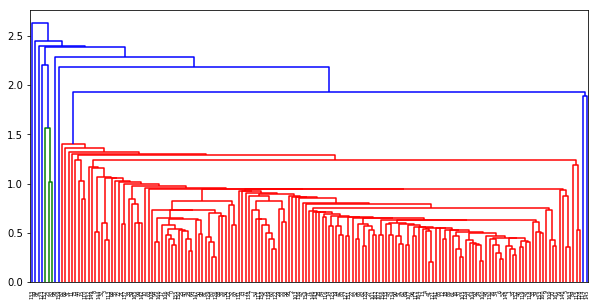

In [198]:
# single linkage
plt.figure(figsize=(10,5))
mergings = linkage(country_df1_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

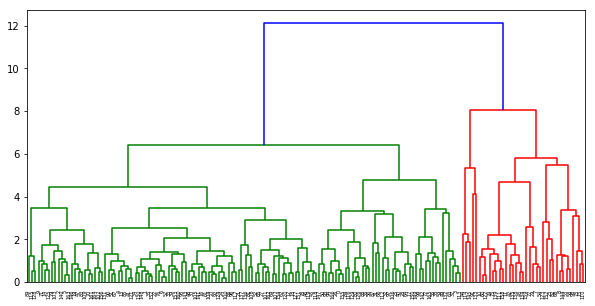

In [199]:
# complete linkage
plt.figure(figsize=(10,5))
mergings = linkage(country_df1_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [200]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [201]:
# assign cluster labels
country_df['cluster_labels'] = cluster_labels
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.82,553.0,0,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090.0,1,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460.0,1,0
3,Angola,119.0,2199.19,100.60,1514.37,5900.0,20.87,60.1,6.16,3530.0,0,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200.0,1,0


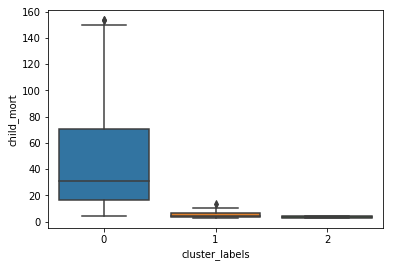

In [202]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=country_df)

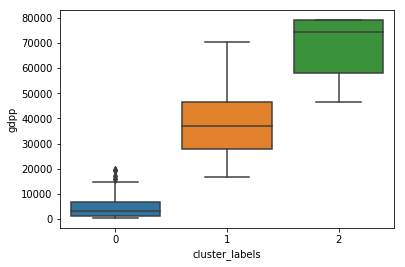

In [203]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=country_df)

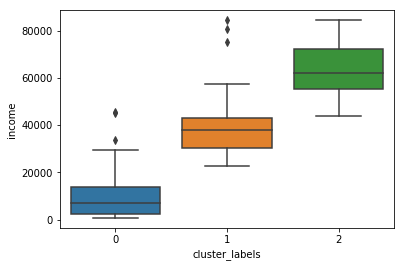

In [204]:
# plots
sns.boxplot(x='cluster_labels', y='income', data=country_df)

In [205]:
country_df.groupby('cluster_labels').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
cluster_labels,,,,,,,,,,
0,47.200769,2084.070412,290.370597,2135.814025,9201.834462,8.179117,68.000923,3.287308,4671.686462,0.630769
1,5.518750,16876.356250,3280.010012,15701.900000,40652.312500,2.611944,79.727188,1.776250,37056.250000,1.781250
2,3.480000,30966.080000,6669.926080,40163.116000,63654.800000,2.612200,81.274000,1.624000,67475.200000,2.000000


###### from all the above three boxplots and the table, it clerarly suggests that cluster_labels 0 has highest child_mort rate and lowest income and gdpp.so we will look at cluster 0 closely.

In [206]:
#Let's use the concept of binning
country_df[country_df['cluster_labels']==0]['country']

0                         Afghanistan
1                             Albania
2                             Algeria
3                              Angola
4                 Antigua and Barbuda
5                           Argentina
6                             Armenia
9                          Azerbaijan
12                         Bangladesh
13                           Barbados
14                            Belarus
16                             Belize
17                              Benin
18                             Bhutan
19                            Bolivia
20             Bosnia and Herzegovina
21                           Botswana
22                             Brazil
24                           Bulgaria
25                       Burkina Faso
26                            Burundi
27                           Cambodia
28                           Cameroon
30                         Cape Verde
31           Central African Republic
32                               Chad
33          

In [207]:
country_df[country_df['cluster_labels']==0].sort_values(by=['gdpp', 'income', 'child_mort'], ascending=[True, True, False]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
88,Liberia,89.3,62.4600,38.5900,302.8000,742.24,5.47,60.8,5.02,331.62,0,0
26,Burundi,93.6,22.2468,26.8000,104.9116,764.00,12.30,57.7,6.26,331.62,0,0
37,"Congo, Dem. Rep.",116.0,137.2700,26.4200,165.6600,742.24,20.80,57.5,6.54,334.00,0,0
112,Niger,123.0,77.2600,17.9600,170.8700,814.00,2.55,58.8,7.49,348.00,0,0
132,Sierra Leone,153.4,67.0300,52.2700,137.6600,1220.00,17.20,55.0,5.20,399.00,0,0
93,Madagascar,62.2,103.2500,17.0088,177.5900,1390.00,8.79,60.8,4.60,413.00,0,0
106,Mozambique,101.0,131.9900,21.8300,193.5800,918.00,7.64,54.5,5.56,419.00,0,0
31,Central African Republic,149.0,52.6300,17.7500,118.1900,888.00,2.01,47.5,5.21,446.00,0,0
94,Malawi,90.5,104.6500,30.2500,160.1900,1030.00,12.10,53.1,5.31,459.00,0,0
50,Eritrea,55.2,23.0900,17.0088,112.3100,1420.00,11.60,61.7,4.61,482.00,0,0


#### the above table shows the top 10 countries with worst(i.e highest) child mortality rate and lowest income and gdpp.

# 5. Final Analysis

###### conclusion:- by using both K-means and heirarchical clustering we got the same list of countires with highest(i.e.worst) child mortality rate w.r.t income and gdpp.
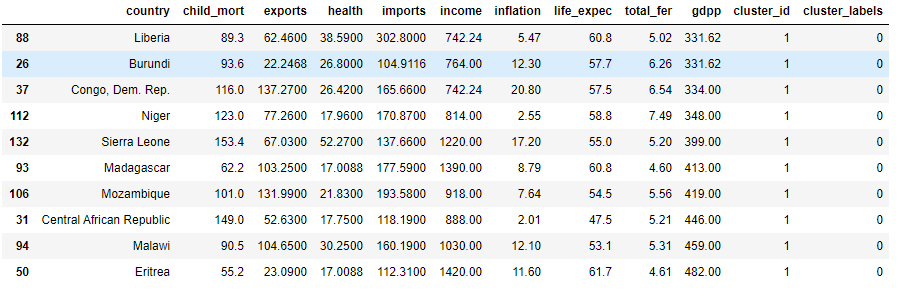

##### these are the top 10 countires that are in urgent need of aid.